In [1]:
from __future__ import print_function, division
import numpy as np
import h5py
import scipy.io
import random
import sys,os
import itertools
import numbers
from collections import Counter
from warnings import warn
from abc import ABCMeta, abstractmethod
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot

In [2]:
import tensorflow as tf

In [3]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(1337)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
#python_random.seed(1337)
random.seed(1337)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1337)
#older version of tensorflow
#tf.set_random_seed(1337)

In [4]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [5]:
num_threads = 8
# Maximum number of threads to use for OpenMP parallel regions.
os.environ["OMP_NUM_THREADS"] = "8"
# Without setting below 2 environment variables, it didn't work for me. Thanks to @cjw85 
os.environ["TF_NUM_INTRAOP_THREADS"] = "8"
os.environ["TF_NUM_INTEROP_THREADS"] = "8"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

In [6]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.regularizers import (
    l2, 
    l1, 
    l1_l2
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import (
    activations, 
    initializers, 
    regularizers, 
    constraints
)

In [7]:
import matplotlib
import matplotlib.pyplot as plt

In [8]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    EarlyStopping
)
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import (
    SelectKBest,
    chi2
)
from collections import defaultdict

In [10]:
from attention_layer import Attention, attention_flatten

In [11]:
def build_model():
	print('building model')

	seq_input_shape = (1000,4)
	nb_filter = 256
	filter_length = 9
	attentionhidden = 256

	seq_input = Input(shape = seq_input_shape, name = 'seq_input')
	convul1   = Convolution1D(filters = nb_filter,
                        	  kernel_size = filter_length,
                        	  padding = 'valid',
                        	  activation = 'relu',
                        	  kernel_constraint = MaxNorm(3)
							  )

	pool_ma1 = MaxPooling1D(pool_size = 3)
	dropout1 = Dropout(0.5977908689086315)
	dropout2 = Dropout(0.50131233477637737)
	decoder  = Attention(hidden = attentionhidden, activation = 'linear')
	dense1   = Dense(1)
	dense2   = Dense(1)

	output_1 = pool_ma1(convul1(seq_input))
	output_2 = dropout1(output_1)
	att_decoder  = decoder(output_2)
	output_3 = attention_flatten(output_2.shape[2])(att_decoder)

	output_4 =  dense1(dropout2(Flatten()(output_2)))
	all_outp =  concatenate([output_3, output_4])
	output_5 =  dense2(all_outp)
	output_f =  Activation('sigmoid')(output_5)

	model = Model(inputs = seq_input, outputs = output_f)
	model.compile(loss = 'binary_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])

	print (model.summary())
	return model


In [12]:
def data_processing():
    x_visdb = np.load('data/x_VISDB_fulldata.npy')
    y_visdb = np.load('data/y_VISDB_fulldata.npy')

    ###split 9:1
    trainx, valx, trainy, valy = train_test_split(x_visdb, y_visdb, test_size = 0.1, stratify=y_visdb #, random_state=42
                                                    )

    ###train 1:1
    neg_train = np.where(trainy == 0)
    pos_train = np.where(trainy == 1)
    trainx_pos = trainx[pos_train]
    trainy_pos = trainy[pos_train]
    trainx_neg = trainx[neg_train]
    trainy_neg = trainy[neg_train]

    ###test 1:1
    neg_val = np.where(valy == 0)
    pos_val = np.where(valy == 1)
    xval_positive = valx[pos_val]
    yval_positive = valy[pos_val]
    xval_negative = valx[neg_val]
    yval_negative = valy[neg_val]

    #np.random.seed(42) 
    permutation = np.random.permutation(xval_negative.shape[0])
    xval_negative_1 = xval_negative[permutation[:xval_positive.shape[0]], :, :]
    yval_negative_1 = yval_negative[permutation[:xval_positive.shape[0]]]

    permutation_train = np.random.permutation(trainy_neg.shape[0])
    trainx_neg_1 = trainx_neg[permutation_train[:trainx_pos.shape[0]],:,:]
    trainy_neg_1 = trainy_neg[permutation_train[:trainx_pos.shape[0]]]

    valx = np.concatenate((xval_positive, xval_negative_1), axis=0)
    valy = np.concatenate((yval_positive, yval_negative_1), axis=0)

    trainx = np.concatenate((trainx_pos, trainx_neg_1), axis = 0)
    trainy = np.concatenate((trainy_pos, trainy_neg_1), axis = 0)

    valx2, valy2 = shuffle(valx, valy#, random_state=42
                            )
    trainx2, trainy2 = shuffle(trainx, trainy #, random_state = 42
                            )
    
    return trainx2, trainy2, valx, valy, valx2, valy2


In [13]:
import gc
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        gc.collect()
        tf.keras.backend.clear_session()

In [14]:
def train_model(trainx, trainy, cv):
    kfold = cv
    for i, (train,test) in enumerate(kfold.split(trainx, trainy)):
        xtrain = trainx[train]
        ytrain = trainy[train]
        testx = trainx[test]
        testy = trainy[test]

        neg_val = np.where(testy == 0)
        pos_val = np.where(testy == 1)
        xval_positive = testx[pos_val]
        yval_positive = testy[pos_val]
        xval_negative = testx[neg_val]
        yval_negative = testy[neg_val]

        x_p = xtrain[np.where(ytrain==1)]
        x_n = xtrain[np.where(ytrain!=1)]

        permutation = np.random.permutation(xval_negative.shape[0])
        xval_negative_1 = xval_negative[permutation[:xval_positive.shape[0]], :, :]
        yval_negative_1 = yval_negative[permutation[:xval_positive.shape[0]]]

        xval_1 = np.concatenate((xval_positive, xval_negative_1), axis=0)
        yval_1 = np.concatenate((yval_positive, yval_negative_1), axis=0)
        xval_2, yval_2 = shuffle(xval_1, yval_1 #, random_state=42
                                )

        slength=int(x_p.shape[0]) #positive data length

        folder = ('model/fullrun/CV_%s/' %i) #set CV iteration folder
        if not os.path.isdir(folder):
            os.makedirs(folder)

        for u in range(10):
            callback_list = [
                EarlyStopping(monitor = 'val_accuracy', patience = 10),
                ModelCheckpoint(filepath = (folder+'model_%s.h5' %u), monitor = 'val_accuracy', mode = 'max', save_best_only= True, save_weights_only = True, verbose = 1),
                MyCustomCallback()
            ]

            if u == 0:
                model = build_model()
            if u == 9:
                x1_n1 = x_n[(slength*u):]
            else:                            
                x1_n1 = x_n[(slength*u):(slength*u+slength)]


            train_x1 = np.concatenate((x_p, x1_n1), axis=0)
            train_yf =  np.concatenate((np.ones((len(x_p),), dtype=np.int),np.zeros((len(x1_n1),), dtype=np.int)), axis=0)

            model.fit(train_x1, train_yf, 
                        validation_data = (xval_2, yval_2),
                        epochs = 100, batch_size = 512, shuffle = True,
                        callbacks = callback_list,
                        verbose = 1)

        del model
        gc.collect()
        tf.keras.backend.clear_session()

In [19]:
def test_model(valx, valy):
        all_probas = np.array([])
        all_labels = np.array([])

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
        figsize=6.2, 6.2

        for i in range(10):
                i1 = i + 1
                neg_val = np.where(valy == 0)
                pos_val = np.where(valy == 1)
                xval_positive = valx[pos_val]
                yval_positive = valy[pos_val]
                xval_negative = valx[neg_val]
                yval_negative = valy[neg_val]

                permutation = np.random.permutation(xval_negative.shape[0])
                xval_negative_1 = xval_negative[permutation[:xval_positive.shape[0]], :, :]
                yval_negative_1 = yval_negative[permutation[:xval_positive.shape[0]]]

                xval_1 = np.concatenate((xval_positive, xval_negative_1), axis=0)
                yval_1 = np.concatenate((yval_positive, yval_negative_1), axis=0)
                xval_2, yval_2 = shuffle(xval_1, yval_1#, random_state=42
                                        )
                x_p = xval_2[np.where(yval_2==1)]
                x_n = xval_2[np.where(yval_2==0)]

                slength=int(x_p.shape[0]) #positive data length

                folder = ('model/fullrun/CV_%s/' %i)
                if not os.path.isdir(folder):
                        os.makedirs(folder)             

                for u in range(10):
                        model = build_model()
                        if u == 9:
                                x1_n1 = x_n[(slength*u):]
                        else:                            
                                x1_n1 = x_n[(slength*u):(slength*u+slength)]

                        xval = np.concatenate((x_p, x1_n1), axis = 0)
                        yval =  np.concatenate((np.ones((len(x_p),), dtype=np.int),np.zeros((len(x1_n1),), dtype=np.int)), axis=0)

                        model.load_weights(folder+'model_%s.h5' %u)
                        y_pred = model.predict(valx, verbose = 1)
                        
                        if u == 0:
                                probas = np.array(y_pred)
                        else:
                                probas = np.column_stack((probas, y_pred))
                        del model
                        gc.collect()
                        tf.keras.backend.clear_session()

                avg_probas = np.array(probas).mean(axis = 1)

                auroc = roc_auc_score(valy, avg_probas)
                fpr, tpr, threshold = roc_curve(valy, avg_probas)
                aupr = average_precision_score(valy, avg_probas)
                pr, rc, threshold = precision_recall_curve(valy, avg_probas)

                if i == 0:
                        figure1, ax1 = plt.subplots(figsize=figsize)
                        ax1.tick_params(labelsize=18)
                        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
                        [label.set_fontname('Times New Roman') for label in labels]  
                        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                        label='Luck', alpha=.8)

                        ax1.plot(fpr, tpr, color='cyan',
                                label=r'DeepHTLV Ensemble Model '+str(i1)+'(AUC = %0.4f)' % (auroc),
                                lw=2, alpha=.8)
                        ax1.set_xlim([-0.05, 1.05])
                        ax1.set_ylim([-0.05, 1.05])
                        ax1.set_xlabel('False Positive Rate', font1)
                        ax1.set_ylabel('True Positive Rate', font1)
                        title1 = 'Cross Validated ROC Curve'
                        ax1.set_title(title1, font1)
                        ax1.legend(loc="lower right")

                        ########PR_figure
                        figure2, ax2 = plt.subplots(figsize=figsize)
                        ax2.tick_params(labelsize=18)
                        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
                        [label.set_fontname('Times New Roman') for label in labels] 

                        ax2.plot(rc, pr, color='cyan',
                                label=r'DeepHTLV Ensemble Model '+str(i1)+ '(AUC = %0.4f)' % aupr,
                                lw=2, alpha=.8)

                        ax2.set_xlim([-0.05, 1.05])
                        ax2.set_ylim([-0.05, 1.05])
                        ax2.set_xlabel('Recall', font1)
                        ax2.set_ylabel('Precision', font1)
                        title2 = 'Cross Validated PR Curve'
                        ax2.set_title(title2, font1)
                        ax2.legend(loc="lower left")
                else:
                        ax1.plot(fpr, tpr,
                                label=r'DeepHTLV Ensemble Model '+str(i1)+ '(AUC = %0.4f)' % (auroc),
                                lw=2, alpha=.8)
                        ax1.legend(loc="lower right")

                        ax2.plot(rc, pr,
                                label=r'DeepHTLV Ensemble Model '+str(i1)+ '(AUC = %0.4f)' % aupr,
                                lw=2, alpha=.8)
                        ax2.legend(loc='lower left')

                print('auroc = ', auroc)
                print('aupr = ', aupr)

                gc.collect()
                tf.keras.backend.clear_session()

                all_probas = np.append(all_probas, avg_probas)
                all_labels = np.append(all_labels, valy)

        np.save('data/fullrun_all_probas.npy', all_probas)
        np.save('data/full_runall_labels.npy', all_labels)

        fpr, tpr, _ = roc_curve(all_labels, all_probas)
        auroc = roc_auc_score(all_labels, all_probas)
        pr, rc, _ = precision_recall_curve(all_labels, all_probas)
        aupr = average_precision_score(all_labels, all_probas)

        #figure3, ax3 = plt.subplots(figsize=figsize)
        #ax3.tick_params(labelsize=18)
        #labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        #[label.set_fontname('Times New Roman') for label in labels]
        #ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        #label='Luck', alpha=.8)

        ax1.plot(fpr, tpr, color='b',
                label=r'DeepHTLV Mean ROC (AUC = %0.4f)' % (auroc),
                lw=2, alpha=.8)
        #ax3.set_xlim([-0.05, 1.05])
        #ax3.set_ylim([-0.05, 1.05])
        #ax3.set_xlabel('False Positive Rate', font1)
        #ax3.set_ylabel('True Positive Rate', font1)
        #title3 = 'Mean Cross Validated ROC Curve'
        #ax3.set_title(title3, font1)
        ax1.legend(loc="lower right")

        #figure4, ax4 = plt.subplots(figsize=figsize)
        #ax4.tick_params(labelsize=18)
        #labels = ax4.get_xticklabels() + ax4.get_yticklabels()
        #[label.set_fontname('Times New Roman') for label in labels] 
        ax2.plot(rc, pr, color='b',
                label=r'DeepHTLV Mean PR (AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        #ax4.set_xlim([-0.05, 1.05])
        #ax4.set_ylim([-0.05, 1.05])
        #ax4.set_xlabel('Recall', font1)
        #ax4.set_ylabel('Precision', font1)
        #title4 = 'Mean Cross Validated PR Curve'
        #ax4.set_title(title4, font1)
        ax2.legend(loc="lower left")

        figure1.savefig('figures/DeepHTLV_fullscript_ROC_CV10.jpg', dpi=300, bbox_inches = 'tight')
        figure2.savefig('figures/DeepHTLV_fullscript_PR_CV10.jpg', dpi = 300, bbox_inches = 'tight')
        #figure3.savefig('figures/DeepHTLV_fullscript_ROC_CV10mean.jpg', dpi = 300, bbox_inches = 'tight')
        #figure4.savefig('figures/DeepHTLV_fullscript_PR_CV10mean.jpg', dpi = 300, bbox_inches = 'tight')


In [16]:
cv = StratifiedKFold(n_splits = 10, shuffle = True#, random_state=1337
                    )
trainx, trainy, valx, valy, valx2, valy2 = data_processing()

building model
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 992, 256)     9472        seq_input[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 330, 256)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 330, 256)     0           max_pooling1d_1[0][0]            
_____________________________________________________________________________

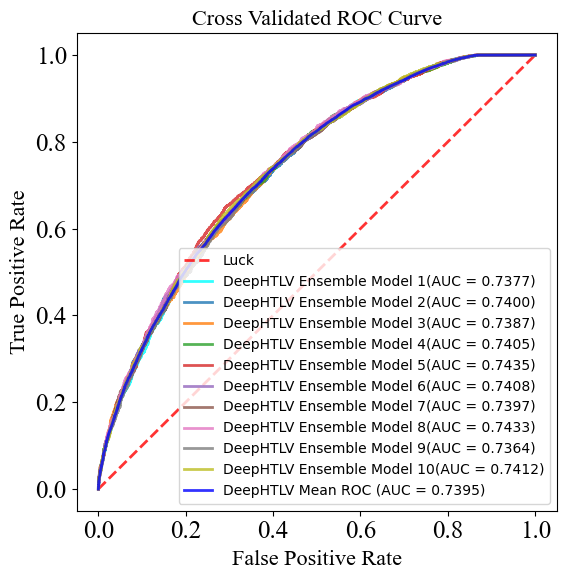

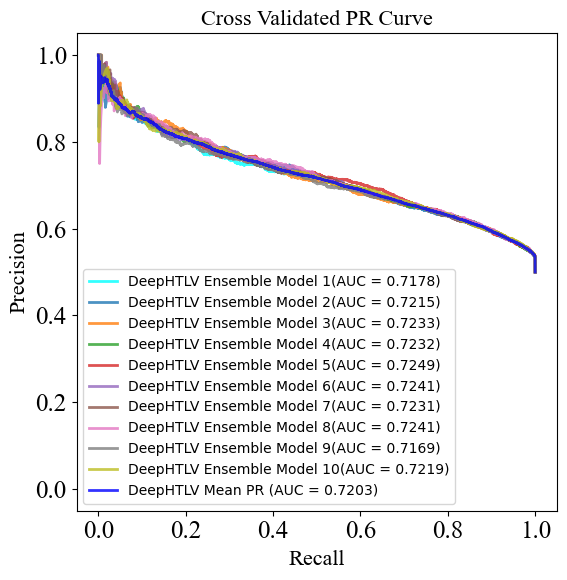

In [20]:
if __name__ == '__main__':
	#train_model(trainx, trainy, cv)
	test_model(valx, valy)

In [24]:
model = build_model()
model.load_weights('model/Final_model.h5')

building model
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 992, 256)     9472        seq_input[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 330, 256)     0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 330, 256)     0           max_pooling1d_2[0][0]            
_____________________________________________________________________________

In [25]:
weights = model.get_weights()
print(weights)

[array([[[ 1.23116467e-02,  1.92237988e-01, -1.70729265e-01, ...,
         -6.14038156e-03,  1.11513674e-01,  1.84248611e-01],
        [ 2.70587243e-02, -1.52121946e-01, -7.03486428e-02, ...,
         -2.34453902e-01,  6.31191880e-02,  1.59803871e-02],
        [-1.99228972e-01, -3.74038726e-01,  1.35150719e-02, ...,
          3.23905945e-02, -2.89771169e-01, -2.22477928e-01],
        [-1.65078998e-01, -1.52042702e-01,  7.47202784e-02, ...,
          7.05870166e-02, -1.18773185e-01, -2.64367849e-01]],

       [[-1.00290045e-01, -1.31265327e-01, -6.00931584e-04, ...,
         -6.40012994e-02, -8.43691155e-02, -9.13716182e-02],
        [ 1.03022449e-01, -4.60754894e-02,  6.55255169e-02, ...,
          5.34741096e-02,  7.49136135e-02, -6.10118620e-02],
        [-2.31606603e-01,  5.07428870e-02, -3.08067560e-01, ...,
          2.67560408e-02, -6.92463741e-02,  1.15330406e-02],
        [ 1.06711481e-02,  5.16311042e-02,  3.98632772e-02, ...,
         -9.50744003e-02, -1.32564351e-01, -5.2842